# **Titanic - Machine Learning from Disaster**


# Table of Contents

* [1: Modules](#Modules)
* [2: Preparing Data](#PreparingData)
    * [2.1: Read Data](#ReadData)
    * [2.2: Missed Data Status](#MissedDataStatus)
    * [2.3: Data Labeling](#DataLabeling)
    * [2.3: Data Visualization](#DataVisualization)
    * [2.3: Imputer Design](#ImputerDesign)
    * [2.3: Encoder Design](#EncoderDesign)
    * [2.3: Drop Useless Features](#DropUselessFeatures)
* [3: Dimensionality Reduction](#DimensionalityReduction)
    * [3.1: Sensitivity Analysis](#SensitivityAnalysis)
        * [3.2: Decide on effective features](#DecideonEffectiveFeatures)
    * [3.3: UMAP Algorithm](#UMAPAlgorithm)
    
* [4: Machine Learning Design](#MachineLearning)
    * [4.1: Scaling](#Scaling)
    * [4.2: Cross Validation Prediction](#CrossValidationPrediction)
    * [4.3: Tuning Hyper Parameters](#TuningHyperParameters)
    * [4.4: Prediction](#Prediction)
    


<a class="anchor" id="Modules"></a>
### **Modules** 

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import math
from sklearn import svm, ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB,CategoricalNB,BernoulliNB,ComplementNB
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


### **Preparing Data** 
<a class="anchor" id="PreparingData"></a>


<a class="anchor" id="ReadData"></a>
#### **Read Data** 

In [2]:
# mdata = pd.read_csv('/kaggle/input/titanic/train.csv')
mdata = pd.read_csv('/kaggle/input/titanic/train.csv')
tdata = pd.read_csv('/kaggle/input/titanic/test.csv')
mdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
mdata.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<a class="anchor" id="MissedDataStatus"></a>
#### **Missed Data Status** 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

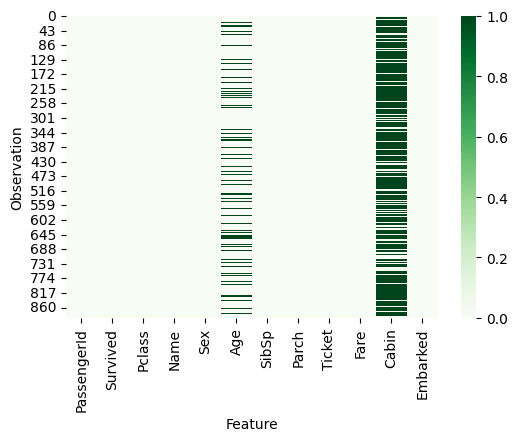

In [4]:
plt.figure(dpi=100)
sns.heatmap(mdata.isnull(), cmap="Greens")
plt.xlabel('Feature')
plt.ylabel('Observation')
mdata.isnull().sum()

<a class="anchor" id="DataLabeling"></a>
#### **Data Labeling**

In [5]:
def data_cleaner(data):
    data["Title"] = data["Name"].apply(lambda x: x[x.find(',') : x.find('.')][1:].strip())
    data["Title"] = data["Title"].apply(lambda x: 'Mr' if x == 'Mr' else x) # Mr
    data["Title"] = data["Title"].apply(lambda x: 'Miss' if x == 'Ms'or x == 'Mme' or x=='Mlle' else x) #Miss
    data["Title"] = data["Title"].apply(lambda x: 'Mrs' if x == 'Mrs' else x) #Mrs
    data["Title"] = data["Title"].apply(lambda x: 'Master' if x == 'Master' else x) #Master
    data["Title"] = data["Title"].apply(lambda x: 'Others' if x != 'Mr' and x != 'Miss' and x!= 'Mrs' and x!= 'Master' else x)

    data["Age_group"] = data["Age"].apply( lambda x: 'KIDs' if math.isnan(x)==False and x<=10 else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'TEENs' if (type(x)!=str and math.isnan(x)==False and x<=20 and x >10) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'YOUNGs' if (type(x)!=str and math.isnan(x)==False and x<=40 and x >20) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'OLDs' if (type(x)!=str and math.isnan(x)==False and x >40) else x)
    
    data["FamSize"] = data["SibSp"]+data["Parch"]
    data["FamSizeLabel"] = data["FamSize"].apply( lambda x: 'Small' if int(x)<=2 else 'Large')

    data["FareInter"] = data["Fare"].apply(   
        lambda x: 'LowFare' if x<=7.910400 else ('MidFar' if float(x)>=7.910400 and float(x)<=14.454200 else "HighFare"))
                                  

    return data

data_cleaner(mdata)
data_cleaner(tdata)
mdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_group,FamSize,FamSizeLabel,FareInter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,YOUNGs,1,Small,LowFare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,YOUNGs,1,Small,HighFare
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,YOUNGs,0,Small,MidFar
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,YOUNGs,1,Small,HighFare
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,YOUNGs,0,Small,MidFar


<a class="anchor" id="DataVisualization"></a>
#### **Data Visualization**

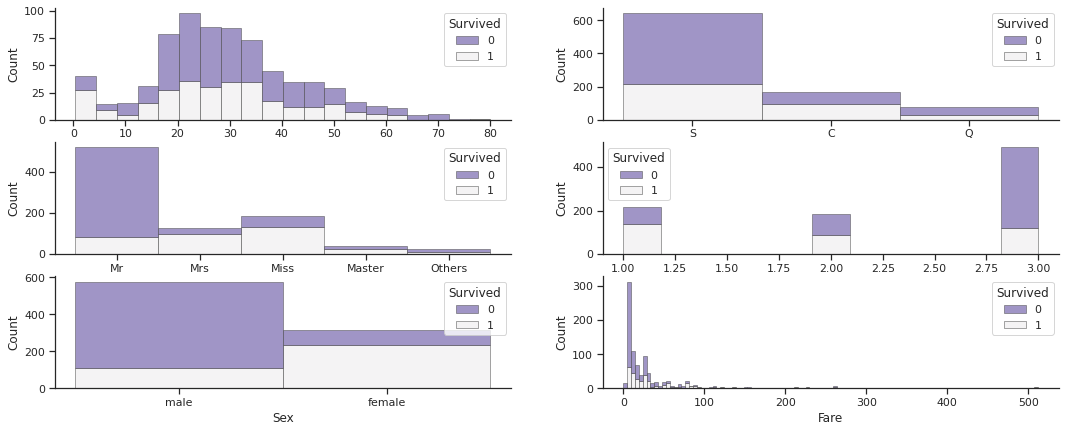

In [6]:
xcol = ["Age","Title", "Sex","Embarked", "Pclass","Fare" ]
huecol = "Survived"
r = 3
c = 2
def mybar(data, xcol, huecol, r, c):
    i = -1
    sns.set_theme(style="ticks")
    f, ax = plt.subplots(r,c,figsize=(18, 7))
    sns.despine(f)
    for col in xcol:
        i+=1
        y = lambda y: int(0) if y<3 else int(1)
        x = lambda x: x if x<3 else int(x-3)
        sns.histplot( data, x=col, hue=huecol, multiple="stack", palette="light:m_r",
            edgecolor=".3", linewidth=.5, log_scale=False,ax = ax[x(i), y(i)])
mybar(mdata, xcol, huecol, r, c)


<a class="anchor" id="ImputerDesign"></a>
#### **Imputer Design**

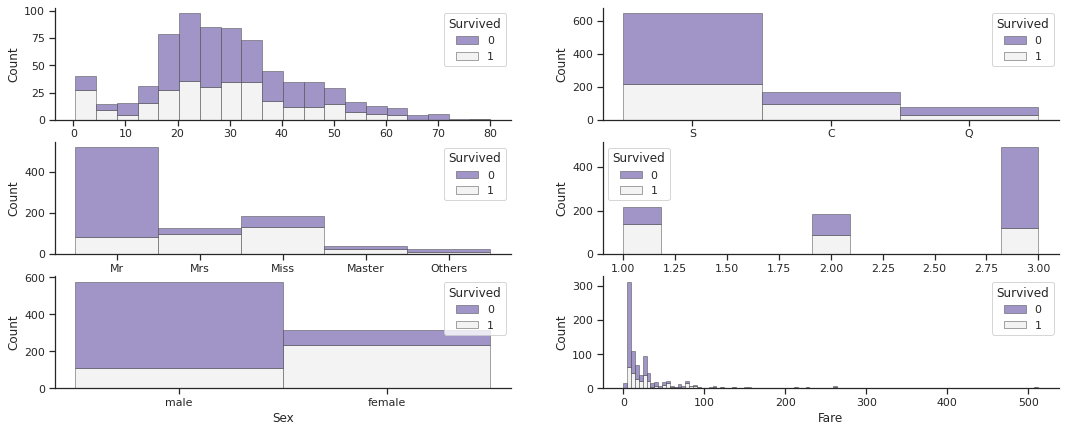

In [7]:
Imputer = SimpleImputer(strategy= 'most_frequent', missing_values=np.nan)
Imputer.fit(mdata[['Age_group']])
mdata[['Age_group']] = Imputer.transform(mdata[["Age_group"]])
Imputer.fit(mdata[['Embarked']])
mdata[['Embarked']] = Imputer.transform(mdata[["Embarked"]])
#-----
Imputer.fit(tdata[['Age_group']])
tdata[['Age_group']] = Imputer.transform(tdata[["Age_group"]])
Imputer.fit(tdata[['Embarked']])
tdata[['Embarked']] = Imputer.transform(tdata[["Embarked"]])
mybar(mdata, xcol, huecol, r, c)

# mean_age_men=mdata[mdata['Sex']=="male"]['Age'].mean()
# mean_age_women=mdata[mdata['Sex']=="female"]['Age'].mean()
# mdata.loc[(mdata.Age.isnull()) & (mdata['Sex']=="female"),'Age']=mean_age_women
# mdata.loc[(mdata.Age.isnull()) & (mdata['Sex']=="male"),'Age']=mean_age_men

# mean_age_men=tdata[tdata['Sex']=="male"]['Age'].mean()
# mean_age_women=tdata[tdata['Sex']=="female"]['Age'].mean()
# tdata.loc[(tdata.Age.isnull()) & (tdata['Sex']=="female"),'Age']=mean_age_women
# tdata.loc[(tdata.Age.isnull()) & (tdata['Sex']=="male"),'Age']=mean_age_men

<a class="anchor" id="EncoderDesign"></a>
#### **Encoder Design**

In [8]:
# Encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

def titanic_encoder(data):
    enc.fit(data[["Embarked"]])
    data[["S","C","Q"]] = \
        pd.DataFrame(enc.transform(data[["Embarked"]]).toarray())
    #----
    enc.fit(data[["Sex"]])
    data[["F","M"]] = \
        pd.DataFrame(enc.transform(data[["Sex"]]).toarray())
    #----
    #----
    enc.fit(data[["Age_group"]])
    data[["Age1","Age2","Age3","Age4"]] = \
        pd.DataFrame(enc.transform(data[["Age_group"]]).toarray())
    #----
    enc.fit(mdata[["FamSizeLabel"]])
    data[["Small","Large"]] = \
        pd.DataFrame(enc.transform(data[["FamSizeLabel"]]).toarray())
    #----
    enc.fit(mdata[["Pclass"]])
    data[["C1","C2","C3"]] = \
        pd.DataFrame(enc.transform(data[["Pclass"]]).toarray())
    #----
    enc.fit(mdata[["FareInter"]])
    data[["F1","F2","F3"]] = \
        pd.DataFrame(enc.transform(data[["FareInter"]]).toarray())
    return data
enc_mdata = titanic_encoder(mdata)
enc_tdata = titanic_encoder(tdata)
enc_mdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age3,Age4,Small,Large,C1,C2,C3,F1,F2,F3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
# MLP for age estimation
from keras.models import Sequential 
from keras.layers import Dense, Activation,Dropout,BatchNormalization
from keras.losses import mse
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
var_col =  ["Small","Large","F1","F2","F3","C1","C2","C3","S","C","Q"]
fit_col = "Age"
mdata1 = mdata.dropna(subset=['Age'], how='all')


y = mdata1[fit_col].values
y=np.reshape(y,(len(y),))
x_train, x_test, y_train, y_test = train_test_split(mdata1[var_col], y,
                                                    train_size=0.9,
                                                    random_state=0)

# scaler=MinMaxScaler().fit(x_train)
# x_train_scaled=scaler.transform(x_train)
y_train_scaled = (y_train-np.min(y_train))/(np.max(y_train)-np.min(y_train))
y_test_scaled = (y_test-np.min(y_test))/(np.max(y_test)-np.min(y_test))
model=Sequential()
# The Input Layer
# f1model.add(Dense(len(var_col),))
model.add(Dense(len(var_col),input_shape=(len(var_col),)))
# The hidden Layers
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

#The output layer
model.compile(optimizer='adam',loss='mse',metrics=['mean_absolute_error'])
checkpoints=ModelCheckpoint(filepath,monitor="loss",save_best_only=True,verbose=1,mode="min")
callbacks_list=[checkpoints]
model.summary()
model.compile(optimizer='adam',loss='mse',metrics=['mean_absolute_error'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
batch_normalization (BatchNo (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1)                 4         
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
Total params: 192
Trainable params: 168
Non-trainable params: 24
_________________________________________________________________


2022-07-25 18:51:18.604707: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
net_data=model.fit(x_train,y_train_scaled,batch_size=12,
                     epochs=100,validation_split=0.05,callbacks=callbacks_list);

Epoch 1/100


2022-07-25 18:51:18.845043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


51/51 [==============================] - 1s 7ms/step - loss: 3.3029 - mean_absolute_error: 1.0940 - val_loss: 0.0511 - val_mean_absolute_error: 0.1978

Epoch 00001: loss improved from inf to 3.30292, saving model to weights.best.hdf5
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 3.5394 - mean_absolute_error: 1.1357 - val_loss: 0.0530 - val_mean_absolute_error: 0.2007

Epoch 00002: loss did not improve from 3.30292
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 2.7302 - mean_absolute_error: 1.0439 - val_loss: 0.0629 - val_mean_absolute_error: 0.2103

Epoch 00003: loss improved from 3.30292 to 2.73022, saving model to weights.best.hdf5
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 2.4240 - mean_absolute_error: 0.9467 - val_loss: 0.0766 - val_mean_absolute_error: 0.2244

Epoch 00004: loss improved from 2.73022 to 2.42405, saving model to weights.best.hdf5
Epoch 5/100
51/51 [==============================] - 0s

In [11]:
scaler=MinMaxScaler().fit(x_test)
x_test_scaled=scaler.transform(x_test)
y_pred = model.predict(x_test_scaled)

<a class="anchor" id="DropUselessFeatures"></a>
#### **Drop Useless Features**
There are some useless columns like "Name", "Cabin" that their information does not contribute in making a model. Moreover those columns whose data are encoded to binaries are also removed. Because I am going to work with the binary data. 

In [12]:
# col = ["Age","PassengerId","Sex","Name","Cabin","Ticket","Embarked","Title","FamSize","SibSp","Parch","Age_group","Pclass","FamSizeLabel",'Fare',"FareInter"]
col = ["PassengerId","Sex","Name","Cabin","Ticket","Embarked","Title","Age_group","Pclass","FamSizeLabel","FareInter"]

mdata_drp = enc_mdata.drop(col,axis = 1)
tdata_drp = enc_tdata.drop(col,axis = 1)


<a class="anchor" id="DimensionalityReduction"></a>
## **Dimensionality Reduction**

<a class="anchor" id="SensitivityAnalysis"></a>
#### **Sensitivity Analysis**

Text(0.0, 1.0, 'A')

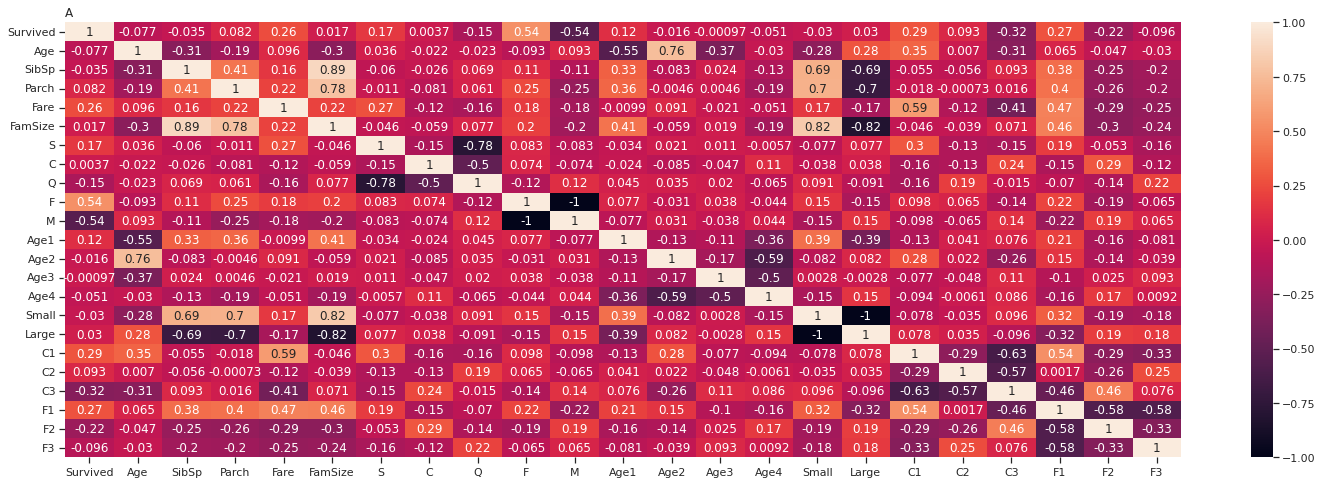

In [13]:
myheatmap=plt.figure(figsize=(25,8))
sns.heatmap(mdata_drp.corr(),annot=True)
plt.title("A",loc='left')

<a class="anchor" id="DecideonEffectiveFeatures"></a>
#### **Decide on Effective Features**

In [14]:
var_col =  ["S","C","F","M","Age1","Age2","Age4","Small","Large","C1","C2","C3",'F1',"F2","F3"]
fit_col = "Survived"
mdata_drp[var_col].head()

,S,C,F,M,Age1,Age2,Age4,Small,Large,C1,C2,C3,F1,F2,F3
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


<a class="anchor" id="UMAPAlgorithm"></a>
#### **UMAP Algorithm**
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

Text(0, 0.5, 'Dim2')

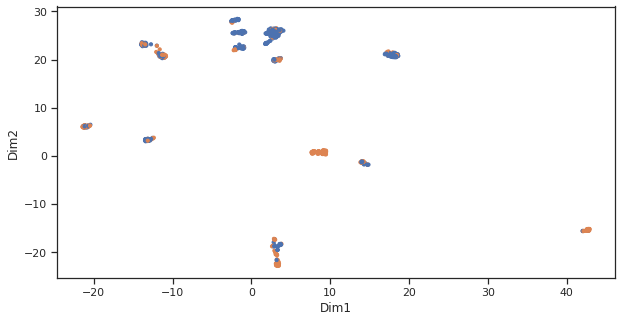

In [15]:
import umap
trans = umap.UMAP(n_neighbors=50, random_state=3, min_dist=0.3,
                      metric='correlation').fit(mdata_drp[var_col])
plt.figure(figsize = (10,5))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 10, c=[sns.color_palette()[x] for x in mdata_drp[fit_col]])
plt.xlabel("Dim1")
plt.ylabel("Dim2")

<a class="anchor" id="UMAPAlgorithm"></a>
#### **PCA Algorithm**

In [16]:
# pca = PCA(n_components=10)
# red_x = pca.fit_transform(mdata_drp[var_col])
# scaler= StandardScaler()
# red_x_std = scaler.fit_transform(red_x)
scaler = MinMaxScaler()
x_std = scaler.fit_transform(mdata_drp[var_col])

Note: UMAP has no good space reduction and the boundaries are not clear. So, I used only sensitivity analysis to drop less effective parameter.

<a class="anchor" id="MachineLearning"></a>
## **Machine Learning**

<a class="anchor" id="Scaling"></a>
#### **Split Data**
Note: All features have been encoded between 0 and 1, so the scaling data has not been employed here.

In [17]:
y = mdata_drp[fit_col].values
y=np.reshape(y,(len(y),))
x_train, x_test, y_train, y_test = train_test_split(x_std, y,
                                                    train_size=0.85,
                                                    random_state=0)


<a class="anchor" id="CrossValidationPrediction"></a>
#### **Cross Validation Prediction**
Note: I am evaluating four different classification mehods.

In [18]:
estimators = [svm.SVC(),
              ensemble.RandomForestClassifier(),
              KNeighborsClassifier(), SGDClassifier(),LogisticRegression()]

for esti in estimators:
    y_pred = cross_val_predict(esti,x_train,y_train,cv=3)
    print(f"\nClassification Report for {esti}:")
    print("Accuracy= ", accuracy_score(y_pred, y_train))
    print(confusion_matrix(y_pred, y_train))
    print(classification_report(y_pred,y_train))
        


Classification Report for SVC():
Accuracy=  0.821664464993395
[[431  96]
 [ 39 191]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.86       527
           1       0.67      0.83      0.74       230

    accuracy                           0.82       757
   macro avg       0.79      0.82      0.80       757
weighted avg       0.84      0.82      0.83       757


Classification Report for RandomForestClassifier():
Accuracy=  0.8110964332892999
[[429 102]
 [ 41 185]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       531
           1       0.64      0.82      0.72       226

    accuracy                           0.81       757
   macro avg       0.78      0.81      0.79       757
weighted avg       0.83      0.81      0.82       757


Classification Report for KNeighborsClassifier():
Accuracy=  0.8124174372523117
[[445 117]
 [ 25 170]]
              precision    recall  f1-score   supp

<a class="anchor" id="TuningHyperParameters"></a>
#### **Tuning Hyper Parameters**

In [19]:
# Parameters of support vector machine

kernel=['poly','rbf','sigmoid']
C= [1,5,10,20,50,100,200,500,1000]
degree = [1,2,3,4]
gamma = ['scale', 'auto']
distributions = {
    "kernel": kernel,
    "C": C,
    "degree":degree,
    "gamma" : gamma,
}

iestimator = RandomizedSearchCV(
    svm.SVC(),
    param_distributions=distributions,
    n_iter = 30
)

iestimator_dict = iestimator.fit(x_train,y_train)
best_config= iestimator_dict.best_estimator_
best_y_pred = cross_val_predict(best_config, x_train,y_train, cv=3)
print("Accuracy= ", accuracy_score(best_y_pred, y_train))
print(confusion_matrix(best_y_pred, y_train))
print(classification_report(best_y_pred,y_train))

Accuracy=  0.8150594451783355
[[429  99]
 [ 41 188]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       528
           1       0.66      0.82      0.73       229

    accuracy                           0.82       757
   macro avg       0.78      0.82      0.79       757
weighted avg       0.83      0.82      0.82       757



In [20]:
# Parameters of random forest

n_estimators= [50,100,500]
criterion = ["gini", "entrop", "log_loss"]
max_depth = [10,50,100]
min_samples_split = [5,10,20,40]
min_samples_leaf = [5,10,20,40]
max_features = ["sqrt","log2"]
distributions = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_depth":max_depth,
    "min_samples_split" : min_samples_split,
    "min_samples_leaf"  : min_samples_leaf,
    "max_features":max_features,
    
}

iestimator = RandomizedSearchCV(
    ensemble.RandomForestClassifier(),
    param_distributions=distributions,
    n_iter = 30
)

iestimator_dict = iestimator.fit(x_train,y_train)
best_config= iestimator_dict.best_estimator_
best_y_pred = cross_val_predict(best_config, x_train,y_train, cv=3)
print("Accuracy= ", accuracy_score(best_y_pred, y_train))
print(confusion_matrix(best_y_pred, y_train))
print(classification_report(best_y_pred,y_train))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
105 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/pa

Accuracy=  0.809775429326288
[[437 111]
 [ 33 176]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       548
           1       0.61      0.84      0.71       209

    accuracy                           0.81       757
   macro avg       0.77      0.82      0.78       757
weighted avg       0.84      0.81      0.82       757



<a class="anchor" id="Prediction"></a>
#### **Prediction**

In [21]:
tdata_final = pd.DataFrame([tdata['PassengerId'],best_config.predict(tdata_drp[var_col])],index = ['PassengerId','Survived']).T
tdata_final.to_csv('./result.csv')

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [22]:
tdata_final

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
